## Importing Models, Required Metrics, Libraries

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS
from sklearn.utils import resample
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.svm import SVC
from tensorflow import keras
import seaborn as sns
import pandas as pd
import numpy as np
import string
import nltk

## Reading File

In [11]:
from google.colab import files
uploaded = files.upload()

In [12]:
ls

sample_data/  spam_dataset.csv


In [14]:
mail=pd.read_csv("spam_dataset.csv",encoding='latin1')
mail.head()

,message_content,is_spam
0,"Hello Lonnie,\n\nJust wanted to touch base reg...",0
1,"Congratulations, you've won a prize! Call us n...",1
2,You have been pre-approved for a credit card w...,1
3,"Limited time offer, act now! Only a few spots ...",1
4,Your loan has been approved! Transfer funds to...,1


In [16]:
mail.shape

(1000, 2)

In [17]:
mail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   message_content  1000 non-null   object
 1   is_spam          1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [19]:
mail.isnull().sum()

,0
message_content,0
is_spam,0


In [20]:
mail.describe()

,is_spam
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [22]:
mail["is_spam"].value_counts()


,count
is_spam,
0,500
1,500


## Data Exploration and Visualization

In [26]:
sns.set_style("whitegrid")

In [27]:
mail_df = mail.copy()

In [28]:
label_counts = mail_df['is_spam'].value_counts()

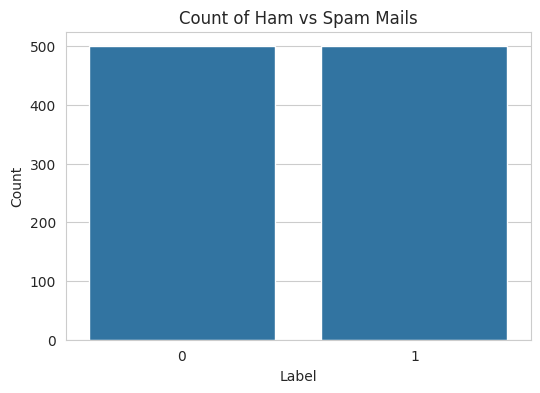

In [30]:
plt.figure(figsize=(6,4))
sns.countplot(data=mail_df, x='is_spam')
plt.title('Count of Ham vs Spam Mails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

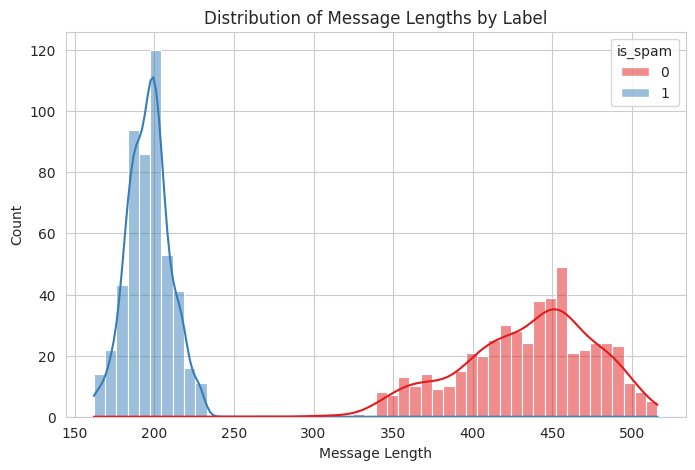

In [31]:
mail_df['message_length'] = mail_df['message_content'].apply(len)

# Distribution of message lengths
plt.figure(figsize=(8,5))
sns.histplot(data=mail_df, x='message_length', hue='is_spam', bins=50, kde=True, palette='Set1')
plt.title('Distribution of Message Lengths by Label')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

In [33]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
def get_top_n_words(messages, n=15):
    words = ' '.join(messages).lower().translate(str.maketrans('', '', string.punctuation)).split()
    words = [word for word in words if word not in stop_words]
    return Counter(words).most_common(n)

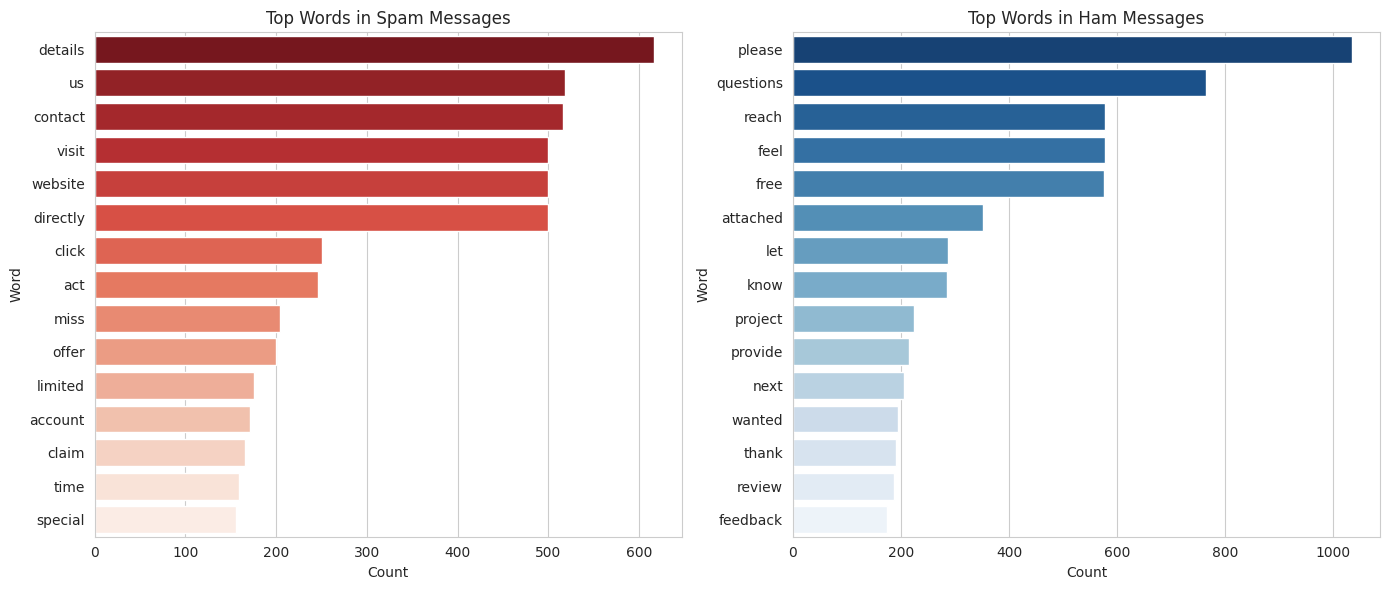

In [36]:
spam_top = get_top_n_words(mail_df[mail_df['is_spam'] == 1]['message_content'])
ham_top = get_top_n_words(mail_df[mail_df['is_spam'] == 0]['message_content'])

# Convert to DataFrames
spam_df = pd.DataFrame(spam_top, columns=['word', 'count'])
ham_df = pd.DataFrame(ham_top, columns=['word', 'count'])

# Convert 'count' to integers
spam_df['count'] = spam_df['count'].astype(int)
ham_df['count'] = ham_df['count'].astype(int)

# Plot side-by-side
plt.figure(figsize=(14,6))

# Spam plot
plt.subplot(1, 2, 1)
sns.barplot(data=spam_df, x='count', y='word', palette='Reds_r')
plt.title('Top Words in Spam Messages')
plt.xlabel('Count')
plt.ylabel('Word')

# Ham plot
plt.subplot(1, 2, 2)
sns.barplot(data=ham_df, x='count', y='word', palette='Blues_r')
plt.title('Top Words in Ham Messages')
plt.xlabel('Count')
plt.ylabel('Word')

plt.tight_layout()
plt.show()

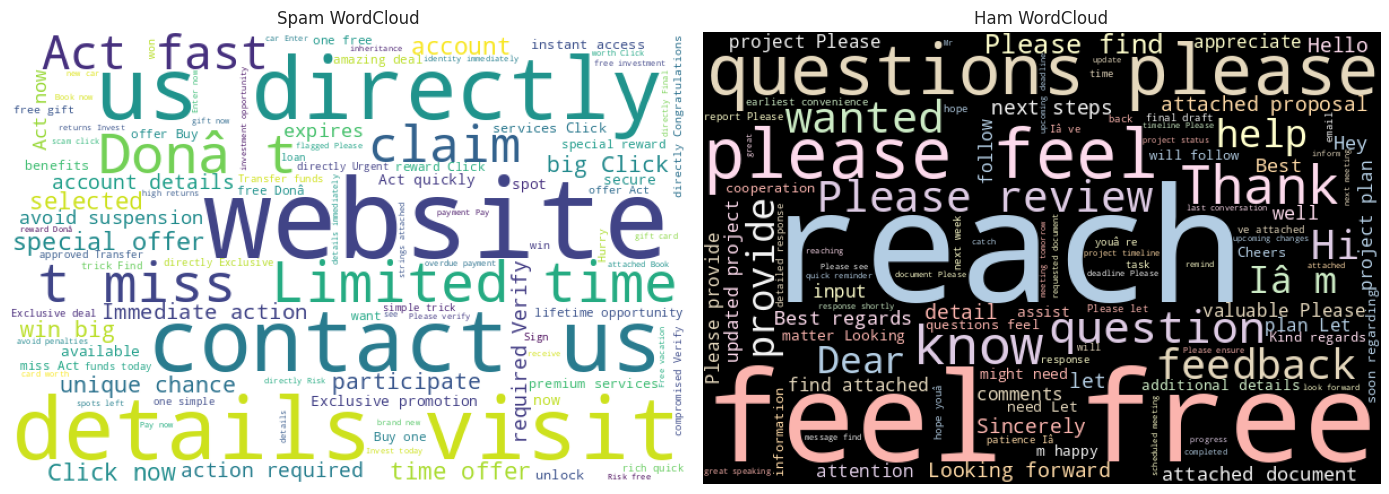

In [37]:
spam_words = ' '.join(mail_df[mail_df['is_spam']== 1]['message_content'])
ham_words = ' '.join(mail_df[mail_df['is_spam']== 0]['message_content'])
custom_stopwords = set(STOPWORDS)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400, background_color='white',
                     stopwords=custom_stopwords, max_words=100).generate(spam_words))
plt.title('Spam WordCloud')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color='black',
                     stopwords=custom_stopwords, colormap='Pastel1', max_words=100).generate(ham_words))
plt.title('Ham WordCloud')
plt.axis('off')
plt.tight_layout()
plt.show()

## Text Preprocessing

In [39]:
def clean_text(text):
   text = text.lower()
   text = ''.join([char for char in text if char not in string.punctuation])
   words = text.split()
   words = [word for word in words if word not in stopwords.words('english')]
   return ' '.join(words)

mail_df['cleaned_message'] = mail_df['message_content'].apply(clean_text)

In [41]:
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X = tfidf.fit_transform(mail_df['cleaned_message']).toarray()
y = mail_df['is_spam']
tfidf

TfidfVectorizer(max_features=3000, ngram_range=(1, 2))

In [42]:
X = np.hstack((X, mail_df['message_length'].values.reshape(-1, 1)))  # Combine with TF-IDF
X

array([[  0.,   0.,   0., ...,   0.,   0., 394.],
       [  0.,   0.,   0., ...,   0.,   0., 204.],
       [  0.,   0.,   0., ...,   0.,   0., 215.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 206.],
       [  0.,   0.,   0., ...,   0.,   0., 198.],
       [  0.,   0.,   0., ...,   0.,   0., 407.]])

## Splitting Data

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Logistic Regression

In [44]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [45]:
scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring='f1')
print("Cross-validated F1 scores:", scores.mean(), "+/-", scores.std())

Cross-validated F1 scores: 1.0 +/- 0.0


In [46]:
y_train_pred_lr = cross_val_predict(log_reg, X_train, y_train, cv=3)
print("LR Train F1-Score:", f1_score(y_train, y_train_pred_lr))

LR Train F1-Score: 1.0


In [47]:
y_pred_lr = log_reg.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred_lr, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00       100
        Spam       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



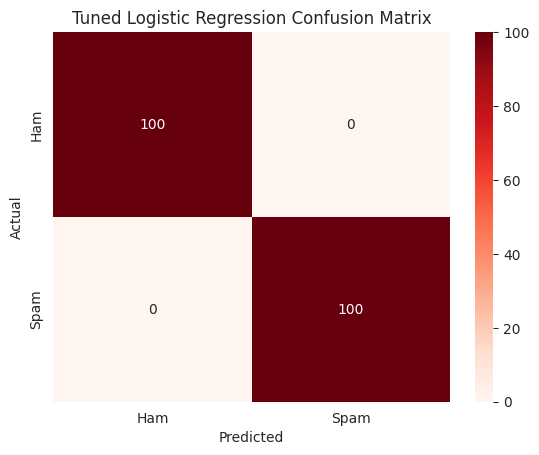

In [50]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Tuned Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [51]:
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 100.00%


In [52]:
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), param_grid_lr, cv=3, scoring='f1')
grid_search_lr.fit(X_train, y_train)
log_reg = grid_search_lr.best_estimator_
y_pred_lr = log_reg.predict(X_test)
print("Best LR params:", grid_search_lr.best_params_)
print("LR Test F1-Score:", f1_score(y_test, y_pred_lr))

Best LR params: {'C': 0.01}
LR Test F1-Score: 1.0


In [53]:
scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring='f1')
print("Cross-validated F1 scores:", scores.mean(), "+/-", scores.std())
y_train_pred_lr = cross_val_predict(log_reg, X_train, y_train, cv=3)
print("LR Train F1-Score:", f1_score(y_train, y_train_pred_lr))

Cross-validated F1 scores: 1.0 +/- 0.0
LR Train F1-Score: 1.0


In [54]:
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))

Precision: 1.0
Recall: 1.0


## LSTM

In [55]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [57]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

# Define parameters
max_words = 1000  # Maximum number of words
max_len = 150  # Maximum sequence length

# Initialize the tokenizer
tok = Tokenizer(num_words=max_words)

# Fit on training text
tok.fit_on_texts(mail_df['cleaned_message'].iloc[y_train.index])

# Convert texts to sequences
sequences = tok.texts_to_sequences(mail_df['cleaned_message'].iloc[y_train.index])

# Pad sequences to ensure equal length
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

print(sequences_matrix.shape)

(800, 150)


In [58]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [59]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 50)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,337 (376.32 KB)

 Trainable params: 96,337 (376.32 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.8060 - loss: 0.6766 - val_accuracy: 1.0000 - val_loss: 0.5827
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 1.0000 - loss: 0.5141 - val_accuracy: 1.0000 - val_loss: 0.1936
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 1.0000 - loss: 0.1382 - val_accuracy: 1.0000 - val_loss: 0.0286
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 1.0000 - loss: 0.0240 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss:

In [62]:
test_sequences = tok.texts_to_sequences(mail_df['cleaned_message'].iloc[y_test.index])
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 6.4411e-04
LSTM Test Accuracy: 100.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00       100
        Spam       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



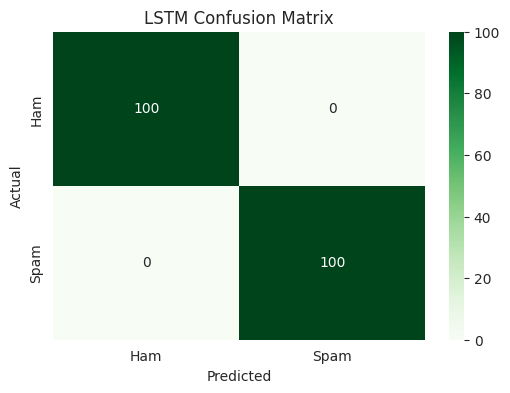

In [63]:
# Evaluate the LSTM model on the test set
lstm_loss, lstm_accuracy = model.evaluate(test_sequences_matrix, y_test)
print(f"LSTM Test Accuracy: {lstm_accuracy*100:.2f}%")

# Predict on the test set and generate classification report and confusion matrix
y_pred_lstm = (model.predict(test_sequences_matrix) > 0.5).astype("int32")

print("\nLSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=['Ham', 'Spam']))

cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

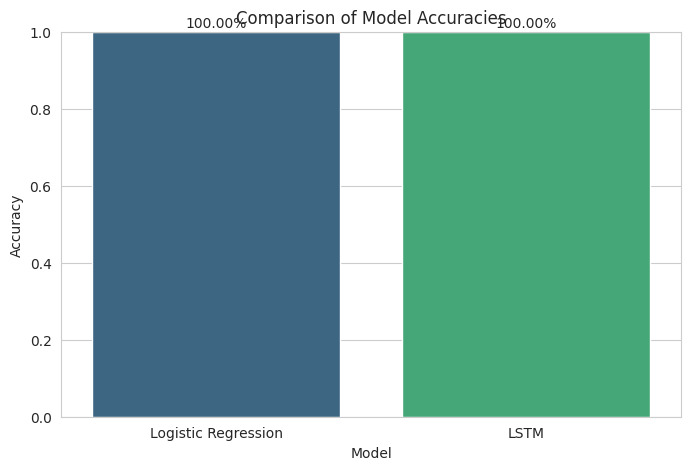


Accuracy Comparison:
Logistic Regression    100.00%
LSTM                   100.00%
dtype: object


In [64]:
# prompt: well now compare the accuracy of the three models that I have trained so far , write code for that and visualize it

# Collect the accuracies of each model
model_accuracies = {
    'Logistic Regression': accuracy_score(y_test, y_pred_lr),
    'LSTM': lstm_accuracy
}

# Create a pandas Series from the accuracies
accuracy_series = pd.Series(model_accuracies)

# Sort the accuracies for better visualization
accuracy_series = accuracy_series.sort_values(ascending=False)

# Visualize the accuracies
plt.figure(figsize=(8, 5))
sns.barplot(x=accuracy_series.index, y=accuracy_series.values, palette='viridis')
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Set the y-axis limit from 0 to 1 (for percentage)

# Add accuracy values on top of the bars
for i, v in enumerate(accuracy_series.values):
    plt.text(i, v + 0.01, f'{v*100:.2f}%', ha='center')

plt.show()

print("\nAccuracy Comparison:")
print(accuracy_series.apply(lambda x: f"{x*100:.2f}%"))


In [66]:
import joblib
from tensorflow.keras.models import save_model
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the save path
base_path = '/content/drive/MyDrive/Colab Notebooks/'  # Change this as needed

# Determine the best model based on accuracy
best_model_name = accuracy_series.idxmax()
print(f"The best model is: {best_model_name}")

# Save the best model


if best_model_name == 'Logistic Regression':
    joblib.dump(log_reg, base_path + 'best_log_reg_model.pkl')
    print("Best Logistic Regression model saved as 'best_log_reg_model.pkl'")
    joblib.dump(tfidf, base_path + 'tfidf_vectorizer.pkl')
    print("TF-IDF Vectorizer saved as 'tfidf_vectorizer.pkl'")

elif best_model_name == 'LSTM':
    save_model(model, base_path + 'best_lstm_model.h5')
    print("Best LSTM model saved as 'best_lstm_model.h5'")
    joblib.dump(tok, base_path + 'tokenizer.pkl')
    print("Tokenizer saved as 'tokenizer.pkl'")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The best model is: Logistic Regression
Best Logistic Regression model saved as 'best_log_reg_model.pkl'
TF-IDF Vectorizer saved as 'tfidf_vectorizer.pkl'


In [68]:
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from google.colab import drive
import joblib
import numpy as np
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))


# Define the path to your Google Drive folder
drive_path = '/content/drive/My Drive/Colab Notebooks/' # Change this as needed

# Mount Google Drive
drive.mount('/content/drive/', force_remount=True)

# Determine the best model name from the accuracy_series variable
# This variable is available in the kernel state from previous execution.
best_model_name = accuracy_series.idxmax()
print(f"The best model is: {best_model_name}")

# Load the trained model based on the best model name
loaded_model = None
if best_model_name == 'SVM':
    model_path = drive_path + 'best_svm_model.pkl'
    loaded_model = joblib.load(model_path)
    print(f"Loaded SVM model from {model_path}")
    tfidf_path = drive_path + 'tfidf_vectorizer.pkl'
    loaded_tfidf = joblib.load(tfidf_path)
    print(f"Loaded TF-IDF Vectorizer from {tfidf_path}")

elif best_model_name == 'Logistic Regression':
    model_path = drive_path + 'best_log_reg_model.pkl'
    loaded_model = joblib.load(model_path)
    print(f"Loaded Logistic Regression model from {model_path}")
    tfidf_path = drive_path + 'tfidf_vectorizer.pkl'
    loaded_tfidf = joblib.load(tfidf_path)
    print(f"Loaded TF-IDF Vectorizer from {tfidf_path}")

elif best_model_name == 'LSTM':
    model_path = drive_path + 'best_lstm_model.h5'
    loaded_model = load_model(model_path)
    print(f"Loaded LSTM model from {model_path}")
    tokenizer_path = drive_path + 'tokenizer.pkl'
    loaded_tokenizer = joblib.load(tokenizer_path)
    print(f"Loaded Tokenizer from {tokenizer_path}")
    max_len = 150 # Ensure this matches the length used during training


def clean_text_for_prediction(text):
   text = text.lower()
   text = ''.join([char for char in text if char not in string.punctuation])
   words = text.split()
   words = [word for word in words if word not in stopwords.words('english')]
   return ' '.join(words)

def predict_message(message):
    cleaned_message = clean_text_for_prediction(message)

    if best_model_name in ['SVM', 'Logistic Regression']:
        # For Logistic Regression, use TF-IDF
        message_vector = loaded_tfidf.transform([cleaned_message]).toarray()
        # Add message length as a feature
        message_length = len(message)
        message_vector = np.hstack((message_vector, [[message_length]]))
        prediction = loaded_model.predict(message_vector)
        # Since these models output 0 or 1 directly
        result = "Spam" if prediction[0] == 1 else "Ham"

    elif best_model_name == 'LSTM':
        # For LSTM, use the tokenizer and pad sequences
        sequence_list = loaded_tokenizer.texts_to_sequences([cleaned_message])
        padded_sequence = sequence.pad_sequences(sequence_list, maxlen=max_len)
        prediction_proba = loaded_model.predict(padded_sequence)
        prediction = (prediction_proba > 0.5).astype("int32")
        result = "Spam" if prediction[0][0] == 1 else "Ham"
    else:
        result = "Could not make a prediction. Model not loaded correctly."

    return result

# Get user input
user_message = input("Enter a mail to check if it's spam: ")

# Make prediction
prediction_result = predict_message(user_message)

print(f"The message is predicted to be: {prediction_result}")

Mounted at /content/drive/
The best model is: Logistic Regression
Loaded Logistic Regression model from /content/drive/My Drive/Colab Notebooks/best_log_reg_model.pkl
Loaded TF-IDF Vectorizer from /content/drive/My Drive/Colab Notebooks/tfidf_vectorizer.pkl
Enter a mail to check if it's spam: Hope you're doing good today, I've some updates about the project and wanted to talk to you about them, are you free tomorrow? 
The message is predicted to be: Spam
